In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
#Import the data into data frame
df = pd.read_csv('twitter_training.csv')

In [3]:
# Check first few rows of the data frame
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
# Check the shape of the data frame
df.shape

(74681, 4)

In [5]:
# Add column headings since they are missing
df.columns = ['tweet_id', 'entity', 'sentiment', 'tweet_content']

In [6]:
# Confirm that column headings are added
df.head()

,tweet_id,entity,sentiment,tweet_content
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
# Confirm that no rows were lost while adding column headings by checking the shape of the data frame
df.shape

(74681, 4)

### Data Clensing

In [8]:
# Delete tweet_id column as it doesn't add value to the analysis
df = df.drop('tweet_id', axis=1)

# Delete entity column as it will not be used during this analysis
df = df.drop('entity', axis=1)

In [9]:
# Check for null values
df.isnull().sum()

sentiment          0
tweet_content    686
dtype: int64

In [10]:
# Drop the rows where tweet_content is null
df = df.dropna()

In [11]:
# Confirm that appropriate number of rows were dropped by checking the shape of the data frame
df.shape

(73995, 2)

### Exploratory Data Analysis

In [12]:
#sentiment count
df.sentiment.value_counts()

Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: sentiment, dtype: int64

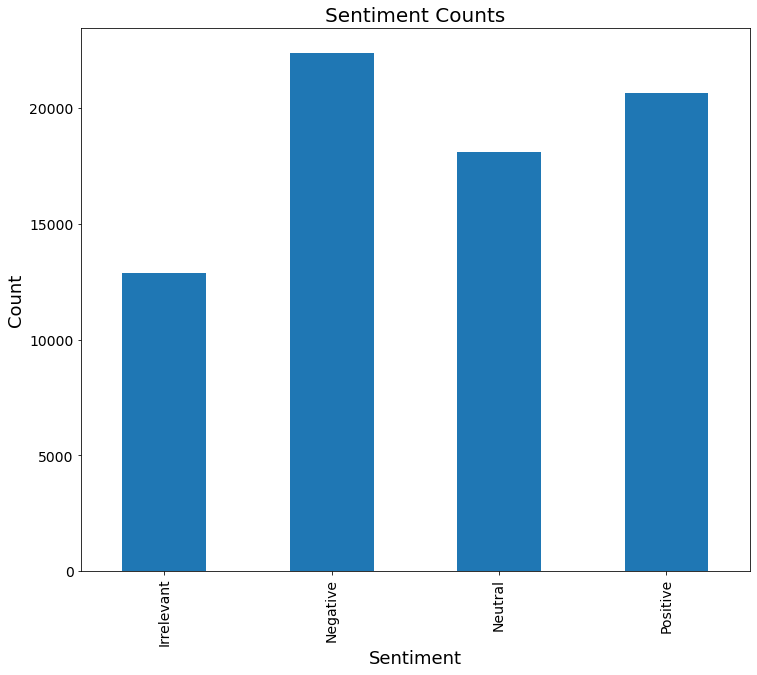

In [13]:
# Display bar chart of sentiments
ax = df['sentiment'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('Sentiment Counts', fontsize=20)
ax.set_xlabel('Sentiment', fontsize=18)
ax.set_ylabel('Count', fontsize=18);
plt.show()

In [14]:
# Convert sentiment values to Numeric: 0 for Neutral and Irrelevant, 1 for Negative, and 2 for Positive
df.sentiment = df.sentiment.apply(lambda x: 1 if x=='Negative' else (2if x=='Positive' else 0))

In [15]:
# Check sentiment value counts after conversion
df.sentiment.value_counts()

0    30983
1    22358
2    20654
Name: sentiment, dtype: int64

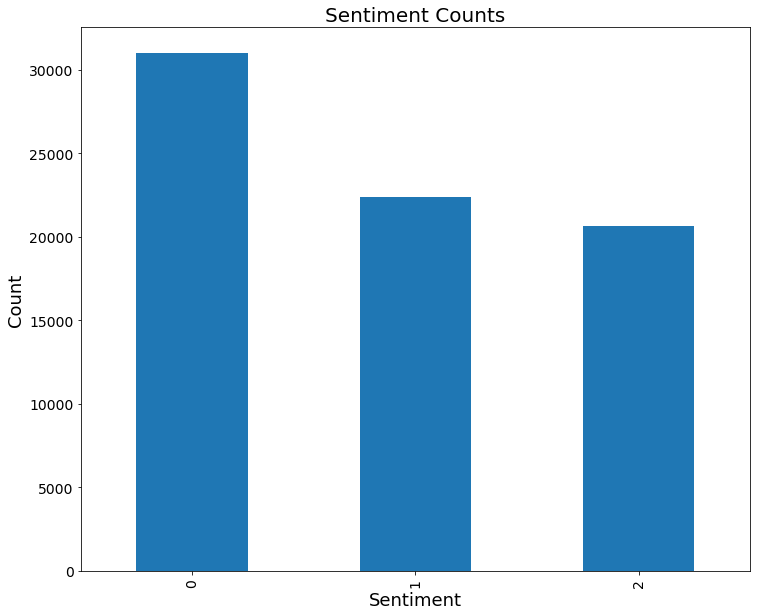

In [16]:
# Display bar chart of sentiment counts after conversion
ax = df['sentiment'].value_counts().sort_index().plot(kind='bar', fontsize=14, figsize=(12,10))
ax.set_title('Sentiment Counts', fontsize=20)
ax.set_xlabel('Sentiment', fontsize=18)
ax.set_ylabel('Count', fontsize=18);
plt.show()

### Pre-processing of tweet_content

In [17]:
# Convert all text in tweet_content to lowercase letters. 
df['tweet_content'] = df['tweet_content'].str.lower()

In [18]:
# Check the first few rows to confirm changes
df.head()

,sentiment,tweet_content
0,2,i am coming to the borders and i will kill you...
1,2,im getting on borderlands and i will kill you ...
2,2,im coming on borderlands and i will murder you...
3,2,im getting on borderlands 2 and i will murder ...
4,2,im getting into borderlands and i can murder y...


In [19]:
# Remove all punctuation from tweet_content using translate method
df['tweet_content'] = df['tweet_content'].str.translate(str.maketrans('','',string.punctuation))

In [20]:
# Check the first few rows to confirm changes
df.head()

,sentiment,tweet_content
0,2,i am coming to the borders and i will kill you...
1,2,im getting on borderlands and i will kill you all
2,2,im coming on borderlands and i will murder you...
3,2,im getting on borderlands 2 and i will murder ...
4,2,im getting into borderlands and i can murder y...


In [21]:
# Download stopwords from nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shilp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Load stop words
stop_words = stopwords.words('english')

In [23]:
#Remove stop words from tweet_content by splitting the text, removing stop words, and then rejoining the text
df['tweet_content'] = df['tweet_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [24]:
# Check the first few rows to confirm changes
df.head()

,sentiment,tweet_content
0,2,coming borders kill
1,2,im getting borderlands kill
2,2,im coming borderlands murder
3,2,im getting borderlands 2 murder
4,2,im getting borderlands murder


In [25]:
# Create a PorterStemmer instance
porter = PorterStemmer()

In [26]:
# Apply PorterStemmer to convert the words in tweet_content to root form
df['tweet_content'] = df['tweet_content'].apply(lambda x: ' '.join([porter.stem(word) for word in x.split()]))

In [27]:
# Check the first few rows to confirm changes
df.head()

,sentiment,tweet_content
0,2,come border kill
1,2,im get borderland kill
2,2,im come borderland murder
3,2,im get borderland 2 murder
4,2,im get borderland murder


### MLP Classifier using Count Vectorizer

In [28]:
# Get sample of 20,000 records due to the size of the data set and performance of the models
new_df = df.sample(20000).copy()

In [29]:
# Create text data
text_data = np.array(new_df['tweet_content'])

In [30]:
# Create bag of words feature matrix
count = CountVectorizer()
X = count.fit_transform(text_data)
y = new_df.sentiment

In [31]:
# Create train and test split with 75% train data and 25% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [32]:
# Apply MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(70, 70, 70))
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(70, 70, 70))

In [33]:
# Create predictions
predictions = mlp.predict(X_test)

In [34]:
# Create confusion matrix
print(confusion_matrix(y_test, predictions))

[[1556  251  266]
 [ 236 1146  131]
 [ 261  129 1024]]


In [35]:
# Print Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      2073
           1       0.75      0.76      0.75      1513
           2       0.72      0.72      0.72      1414

    accuracy                           0.75      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.75      0.75      0.75      5000



In [36]:
# Calculate Accuracy Score
print(accuracy_score(y_test, predictions))

0.7452


### Keras Sequential Classifier using Count Vectorizer

In [37]:
# Convert y_train and y_test as arrays
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [38]:
# Check the shape of X_train, X_test, y_train, and y_test. Use number of features in X_train or X_test to set N_FEATURES 
print(str(X_train.shape))
print(str(X_test.shape))
print(str(y_train.shape))
print(str(y_test.shape))

(15000, 20601)
(5000, 20601)
(15000,)
(5000,)


In [39]:
# Set features and classes
N_FEATURES = X_train.shape[1]
N_CLASSES = 1

In [40]:
# Define function to convert sparse matrix to sparse tensor
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

In [41]:
# Convert to Sparse Tensor 
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

In [42]:
# Create keras sequential classifier 
nn = Sequential()
nn.add(Dense(300, activation='relu', input_dim=N_FEATURES))
nn.add(Dense(700, activation='relu'))
nn.add(Dense(10, activation='softmax'))

# Compile the Artificial Neural Network
nn.compile(loss='sparse_categorical_crossentropy', 
           optimizer='adam', 
           metrics=['accuracy'])

In [43]:
# fit ANN to the training set
nn.fit(X_train, y_train, batch_size=500, epochs=10, verbose=1)

Epoch 1/10


C:\Users\shilp\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 300), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


30/30 [==============================] - 2s 46ms/step - loss: 1.3163 - accuracy: 0.5051
Epoch 2/10
30/30 [==============================] - 1s 47ms/step - loss: 0.5777 - accuracy: 0.7619
Epoch 3/10
30/30 [==============================] - 1s 47ms/step - loss: 0.3241 - accuracy: 0.8782
Epoch 4/10
30/30 [==============================] - 1s 48ms/step - loss: 0.2038 - accuracy: 0.9247
Epoch 5/10
30/30 [==============================] - 1s 48ms/step - loss: 0.1463 - accuracy: 0.9454
Epoch 6/10
30/30 [==============================] - 1s 49ms/step - loss: 0.1125 - accuracy: 0.9580
Epoch 7/10
30/30 [==============================] - 2s 55ms/step - loss: 0.0946 - accuracy: 0.9645
Epoch 8/10
30/30 [==============================] - 2s 50ms/step - loss: 0.0829 - accuracy: 0.9679
Epoch 9/10
30/30 [==============================] - 1s 49ms/step - loss: 0.0766 - accuracy: 0.9709
Epoch 10/10
30/30 [==============================] - 2s 50ms/step - loss: 0.0680 - accuracy: 0.9741


In [44]:
# create prediction
y_pred = np.argmax(nn.predict(X_test), axis=-1)

In [45]:
print(confusion_matrix(y_test, y_pred))

[[1561  230  282]
 [ 274 1099  140]
 [ 290  116 1008]]


In [46]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2073
           1       0.76      0.73      0.74      1513
           2       0.70      0.71      0.71      1414

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



In [47]:
print(accuracy_score(y_test,y_pred))

0.7336


### MLP Classifier using TF-IDF Vectorizer

In [48]:
# Initialize Vectorizer
vectorizer = TfidfVectorizer()

# Fit Vectorizer 
X = vectorizer.fit_transform(new_df['tweet_content'])
y = new_df['sentiment']

In [49]:
# Create train and test split with 75% train data and 25% test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [50]:
# Apply MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(70, 70, 70))
mlp.fit(X_train,y_train)

MLPClassifier(hidden_layer_sizes=(70, 70, 70))

In [51]:
# Create predictions
predictions = mlp.predict(X_test)

In [52]:
# Create confusion matrix
print(confusion_matrix(y_test, predictions))

[[1555  251  267]
 [ 289 1087  137]
 [ 296  120  998]]


In [53]:
# Print Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2073
           1       0.75      0.72      0.73      1513
           2       0.71      0.71      0.71      1414

    accuracy                           0.73      5000
   macro avg       0.73      0.72      0.73      5000
weighted avg       0.73      0.73      0.73      5000



In [54]:
# Calculate Accuracy Score
print(accuracy_score(y_test, predictions))

0.728


### Keras Sequential Classifier using TF-IDF Vectorizer

In [55]:
# Convert y_train and y_test as arrays
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [56]:
# Check the shape of X_train, X_test, y_train, and y_test. Use number of features in X_train or X_test to set N_FEATURES 
print(str(X_train.shape))
print(str(X_test.shape))
print(str(y_train.shape))
print(str(y_test.shape))

(15000, 20601)
(5000, 20601)
(15000,)
(5000,)


In [57]:
# Set features and classes
N_FEATURES = X_train.shape[1]
N_CLASSES = 1

In [58]:
# Convert to Sparse Tensor 
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

In [59]:
# Create keras sequential classifier 
nn = Sequential()
nn.add(Dense(300, activation='relu', input_dim=N_FEATURES))
nn.add(Dense(700, activation='relu'))
nn.add(Dense(10, activation='softmax'))

# Compile the Artificial Neural Network
nn.compile(loss='sparse_categorical_crossentropy', 
           optimizer='adam', 
           metrics=['accuracy'])

In [60]:
# fit ANN to the training set
nn.fit(X_train, y_train, batch_size=500, epochs=10, verbose=1)

Epoch 1/10


C:\Users\shilp\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape:0", shape=(None, 300), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


30/30 [==============================] - 2s 45ms/step - loss: 1.4984 - accuracy: 0.4260
Epoch 2/10
30/30 [==============================] - 1s 45ms/step - loss: 0.7729 - accuracy: 0.7021
Epoch 3/10
30/30 [==============================] - 1s 44ms/step - loss: 0.4102 - accuracy: 0.8496
Epoch 4/10
30/30 [==============================] - 1s 45ms/step - loss: 0.2495 - accuracy: 0.9121
Epoch 5/10
30/30 [==============================] - 1s 44ms/step - loss: 0.1785 - accuracy: 0.9375
Epoch 6/10
30/30 [==============================] - 1s 45ms/step - loss: 0.1390 - accuracy: 0.9506
Epoch 7/10
30/30 [==============================] - 1s 47ms/step - loss: 0.1164 - accuracy: 0.9570
Epoch 8/10
30/30 [==============================] - 1s 47ms/step - loss: 0.1013 - accuracy: 0.9621
Epoch 9/10
30/30 [==============================] - 1s 46ms/step - loss: 0.0877 - accuracy: 0.9671
Epoch 10/10
30/30 [==============================] - 1s 48ms/step - loss: 0.0786 - accuracy: 0.9702


In [61]:
# create prediction
y_pred = np.argmax(nn.predict(X_test), axis=-1)

In [62]:
print(confusion_matrix(y_test, y_pred))

[[1514  268  291]
 [ 270 1116  127]
 [ 298  137  979]]


In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2073
           1       0.73      0.74      0.74      1513
           2       0.70      0.69      0.70      1414

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000



In [64]:
print(accuracy_score(y_test,y_pred))

0.7218
